# Amazon Prime Catalog — Exploratory Data Analysis (EDA)

This notebook explores a publicly available Amazon Prime catalog dataset.

**Goals**
- Understand catalog composition (Movies vs TV Shows)
- Inspect runtime (mins) vs seasons distributions
- Explore genre and country distributions
- Explore cast-size patterns and “unique actors per genre”

## Reproducibility & Assumptions

- The dataset is *catalog-level* metadata (no user watch history).
- File paths are relative so this notebook runs after cloning the repo.
- Cleaning is handled by `clean_streaming_df()` from `streaming_func.py`.

In [1]:
# Config
PLATFORM = "Amazon Prime"
TOP_N = 10
MAX_SEASONS = 10

In [2]:
# Import core libraries and project utilities
from pathlib import Path

import numpy as np
import pandas as pd
from itertools import chain
import matplotlib.pyplot as plt

from streaming_func import clean_streaming_df, unique_actors_per_genre, plot_top_unique_actors

ImportError: cannot import name 'plot_top_unique_actors' from 'streaming_func' (/Users/jonaskorganas/coding_projects/streaming_analysis/streaming_func.py)

In [ ]:
# Loading Amazon Prime csv dataset & displaying first few entries for understanding structure & content
DATA_DIR = Path("data")
CSV_PATH = DATA_DIR / "amazon_prime_titles.csv"

amazon_df = pd.read_csv(CSV_PATH)
amazon_df.head()

## Cleaning

Here, we standardise:
- column names
- multi-value columns (`cast`, `country`, `listed_in`) into Python lists
- duration into two numeric columns:
  - `duration_mins` for Movies
  - `duration_seasons` for TV Shows

### Note on platform-specific cleaning

Earlier iterations of this notebook included an Amazon-specific cleaning function.
This logic has been moved into `streaming_func.py` to keep notebooks lightweight, reusable, & focused on analysis.

The `clean_streaming_df()` function standardises column formats & converts multi-value fields (cast/country/genres) into lists, which enables consistent EDA across platforms.

In [ ]:
# Using refined imported general use cleaning function from streaming_func.py to clean the Amazon Prime dataset
clean_amazon_df = clean_streaming_df(amazon_df)
clean_amazon_df.head()

## Quick dataset breadth checks (genres & production countries)

Before plotting, we compute how many unique genres & countries appear in the catalog.
This is a simple “breadth” sanity-check that also helps interpret long-tail plots later.

In [ ]:
# Extracting unique genre types & countries from the 'listed_in' & 'country' columns respectively for Amazon Prime dataset
amazon_prime_genres = sorted(set(chain.from_iterable(clean_amazon_df["listed_in"])))
amazon_prime_countries = sorted(set(chain.from_iterable(clean_amazon_df["country"])))

print(f'Total unique genres for Amazon Prime media: {len(amazon_prime_genres)}')
print(f'Total unique production countries for Amazon Prime media: {len(amazon_prime_countries)}')

Total number unique genres for Amazon Prime media: 31
Total number unique countries for Amazon Prime media production: 45


## Split into Movies vs TV Shows

Many analyses differ by type (e.g. duration in minutes vs seasons), so we create two filtered dataframes.

In [ ]:
# Movies-only & TV-Shows-only dataframe partitions of the cleaned Amazon Prime dataset
clean_movies_df = clean_amazon_df[clean_amazon_df["type"] == "Movie"].copy()
clean_shows_df = clean_amazon_df[clean_amazon_df["type"] == "TV Show"].copy()

clean_movies_df.shape, clean_shows_df.shape

((7814, 14), (1854, 14))

## Movie runtime distribution (minutes)

We inspect the distribution of movie runtimes to understand typical lengths & whether outliers exist.


### Movie Runtime Distribution

To understand the typical length of movies on Amazon Prime, I visualised the
distribution of movie runtimes. Extreme outliers (very long runtimes, e.g.
special editions or misclassified entries) were excluded to avoid skewing the
visualisation.

The distribution shows a strong concentration around standard feature-length
films (~90 minutes), with a right-skewed tail representing longer productions.

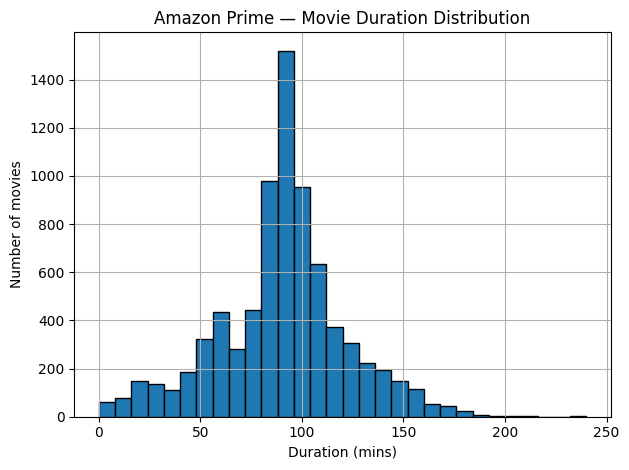

In [ ]:
# Focus on typical feature-length films (exclude extreme outliers)
filtered_movies = clean_movies_df[clean_movies_df["duration_mins"] <= 250]

filtered_movies["duration_mins"].dropna().astype(int).hist(
    bins=30,
    edgecolor="black"
)

plt.title("Amazon Prime — Movie Duration Distribution")
plt.xlabel("Duration (mins)")
plt.ylabel("Number of movies")
plt.tight_layout()
plt.show()

> *Findings:* Movie runtimes cluster around typical feature-length durations, with a long tail of unusually short/long titles. Outliers are expected due to specials, compilations, & metadata noise.

## TV Show seasons distribution

Here, we inspect how many seasons TV shows typically have.

To keep the plot readable, we focus on shows up to a chosen season threshold (long-running outliers exist).

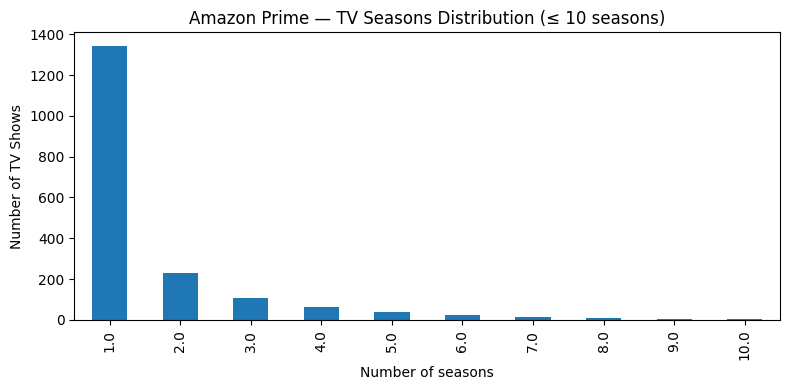

In [ ]:
# Filtering for TV shows with 10 seasons or less, as few tv shows ever suceed enough to exceed this number
max_seasons = 10

filtered_tv = clean_shows_df[clean_shows_df["duration_seasons"].notna() & (clean_shows_df["duration_seasons"] <= max_seasons)]

shows_ax = filtered_tv.groupby("duration_seasons").size().plot(kind="bar", figsize=(8,4))
shows_ax.set_title(f"Amazon Prime — TV Seasons Distribution (≤ {max_seasons} seasons)")
shows_ax.set_xlabel("Number of seasons")
shows_ax.set_ylabel("Number of TV Shows")
plt.tight_layout()
plt.show()

> *Findings:* Most shows have relatively few seasons, with a small number of long-running series creating a long tail.
Filtering improves readability without changing the overall pattern.

## Cast size patterns

Cast lists are imperfect metadata but can still reveal structure:
- TV shows may have larger or more variable casts than movies
- long tails are expected (ensembles / anthology listings)

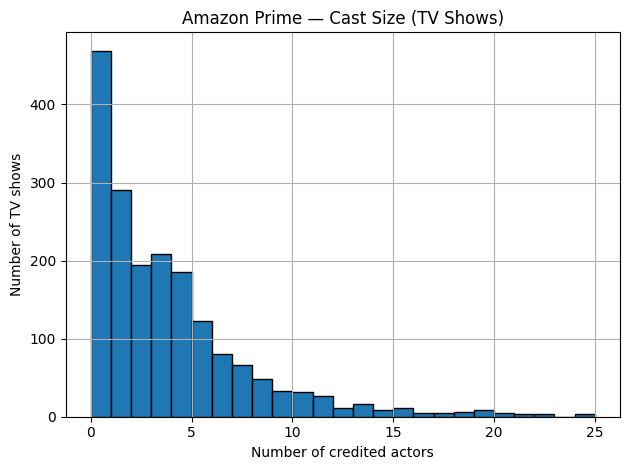

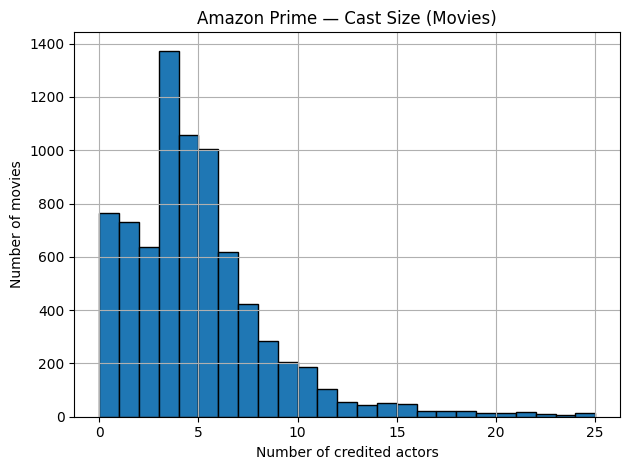

In [ ]:
# Histograms of cast sizes in Movies & TV Shows on Amazon Prime
shows_cast = clean_shows_df.assign(cast_count=clean_shows_df["cast"].apply(len))
movies_cast = clean_movies_df.assign(cast_count=clean_movies_df["cast"].apply(len))

shows_cast["cast_count"].hist(bins=range(0, 26), edgecolor='black')
plt.title("Amazon Prime — Cast Size (TV Shows)")
plt.xlabel("Number of credited actors")
plt.ylabel("Number of TV shows")
plt.tight_layout()
plt.show()

movies_cast["cast_count"].hist(bins=range(0, 26), edgecolor='black')
plt.title("Amazon Prime — Cast Size (Movies)")
plt.xlabel("Number of credited actors")
plt.ylabel("Number of movies")
plt.tight_layout()
plt.show()


> *Findings:* Cast-size distributions are right-skewed (many small casts, fewer large ensembles).
This suggests using medians/quantiles when comparing platforms rather than means.

## Unique cast members (sanity check)

We compute the number of unique credited cast names across the catalog.
This is a rough indicator of metadata richness & helps interpret genre/cast aggregation later.

In [ ]:
# Extracting unique cast members from the Amazon Prime dataset
amazon_unique_cast = sorted(
    set(actor.strip() for actor in chain.from_iterable(clean_amazon_df["cast"]) if isinstance(actor, str) and actor.strip())
)

print(f"Total unique cast members (Amazon Prime): {len(amazon_unique_cast)}")

Total unique cast members (Amazon Prime): 31848


## Genre-level aggregation (using exploded rows)

In the dataframes of the streaming service, genres are multi-label. To aggregate per genre, we explode `listed_in` so each title contributes to each of its genres.
We then compute cast-related aggregates per genre to explore whether some genres tend to have larger ensembles.

In [ ]:
movies_exploded = clean_movies_df.explode("listed_in").assign(cast_count=clean_movies_df["cast"].apply(len))
shows_exploded  = clean_shows_df.explode("listed_in").assign(cast_count=clean_shows_df["cast"].apply(len))

movie_genre_cast = movies_exploded.groupby("listed_in")["cast_count"].sum().sort_values(ascending=False)
show_genre_cast  = shows_exploded.groupby("listed_in")["cast_count"].sum().sort_values(ascending=False)

print(f'{movie_genre_cast.head(10)} \n\n{show_genre_cast.head(10)}')

listed_in
Drama               18423
Comedy               9804
Action               8357
Suspense             7936
Horror               4171
Romance              3271
Science Fiction      2175
Documentary          2110
Kids                 1936
Special Interest     1670
Name: cast_count, dtype: int64 

listed_in
Drama               2665
Comedy              1380
Kids                1119
TV Shows             741
Suspense             710
Action               677
Documentary          554
Animation            530
Special Interest     477
Romance              450
Name: cast_count, dtype: int64


> *Findings:* Genre aggregates show strong concentration: a small number of genres dominate total credited cast counts.
This likely reflects both catalog size per genre & metadata completeness.

## Unique actors per genre (top N)

We estimate how many distinct cast names appear within each genre.
This is not a perfect measure (metadata quality varies), but it’s a useful proxy for genre “breadth”.

> *Note:* I initially explored a pie chart for this comparison, but switched to a horizontal bar chart for improved readability and easier comparison across genres.

In [ ]:
# movie_unique_actors_per_genre = unique_actors_per_genre(clean_movies_df)
# tv_unique_actors_per_genre = unique_actors_per_genre(clean_shows_df)

# top_n = 10
# top_movie_actors_per_genre = movie_unique_actors_per_genre.head(top_n).sort_values()
# top_tv_actors_per_genre = tv_unique_actors_per_genre.head(top_n).sort_values()

# top_movie_actors_per_genre.plot(kind="barh", figsize=(10,4))
# plt.title("Amazon Prime — Share of Unique Actors by Genre (Top 10, Movies)")
# plt.xlabel("Number of unique actors")
# plt.ylabel("Genre")
# plt.tight_layout()
# plt.show()

# top_tv_actors_per_genre.plot(kind="barh", figsize=(10,4))
# plt.title("Amazon Prime — Share of Unique Actors by Genre (Top 10, TV Shows)")
# plt.xlabel("Number of unique actors")
# plt.ylabel("Genre")
# plt.tight_layout()
# plt.show()


movie_unique_actors_per_genre = unique_actors_per_genre(clean_movies_df)
tv_unique_actors_per_genre = unique_actors_per_genre(clean_shows_df)

plot_top_unique_actors(movie_unique_actors_per_genre, "Amazon Prime — Share of Unique Actors by Genre (Top 10, Movies)")
plot_top_unique_actors(tv_unique_actors_per_genre, "Amazon Prime — Share of Unique Actors by Genre (Top 10, TV Shows)")

NameError: name 'plot_top_unique_actors' is not defined

In [ ]:
# Pie chart of unique countries where TV-shows are made per tv-show genre (top 8 countries only)

top_show_n = 8  # limited to 8 for readability of pie chart

# Explode list-of-countries into one country per row, whilst dropping any 'empties' / 'missing' values present in the 'country' column
show_countries = clean_shows_df["country"].explode().dropna()
show_countries = show_countries[show_countries != ""]   # just in case; (after explode, rows that were [] become NaN & get dropped)

'''
Now, we count & plot the top countries, though we can only show a limited number in a pie chart, 
so we pick top_n of 8 in order to have a readable chart. Though there are more countries in the dataset, 
the pie chart would become unreadable with too many slices, due to shares taken by 'other' countries 
that are more popular to film & produce media in than the rest.
'''

top_show_countries = show_countries.value_counts().head(top_show_n)

plt.figure(figsize=(14, 8))
top_show_countries.plot(
    kind="pie", 
    autopct="%1.1f%%", 
    startangle=90
)
plt.ylabel("") # hide default y-axis label
plt.title("Share of TV Shows by Country on Amazon Prime (Top 8 Countries)")
plt.tight_layout()
plt.show()

In [ ]:
# Pie chart of unique countries where movies are produced per movie genre

top_movie_n = 7  # limited to 7 for readability of pie chart

# Explode list-of-countries into one country per row
movie_countries = clean_movies_df["country"].explode()

# As a precaution, drop any 'empties' / 'missing' values present in the 'country' column
movie_countries = movie_countries.dropna()
movie_countries = movie_countries[movie_countries != ""]

'''
Here we can only shown an even more limited number of countries in a pie chart, 
so we pick top_n of 7 in order to have a readable chart. Though there are more countries in the dataset, 
the pie chart would become unreadable with too many slices, due to shares taken by 'other' countries 
that are more popular to film & produce media in than the rest.
'''

top_movie_countries = movie_countries.value_counts().head(top_movie_n)

plt.figure(figsize=(12, 8))
top_movie_countries.plot(
    kind="pie", 
    autopct="%1.1f%%", 
    startangle=90
)
plt.ylabel("")
plt.title("Share of Movies by Country on Amazon Prime (Top 7 Countries)")
plt.tight_layout()
plt.show()

In [ ]:
# Pie chart showing the share of Amazon Prime titles by country of production

top_n = 8  # limited to 8 for readability of pie chart

# Explode converts each list into separate rows so each country is counted individually
media_countries = clean_amazon_df["country"].explode()

# As a precaution, remove missing or empty entries that result from empty lists
media_countries = media_countries.dropna()
media_countries = media_countries[media_countries != ""]   # extra safeguard

# Count how many titles are associated with each country
top_media_countries = media_countries.value_counts().head(top_n)

'''
Due to the smaller variety of countries in the Amazon Prime dataset being used more for media production,
the pie chart can accommodate a slightly lower number of countries (top 8) without becoming unreadable, compared to other platforms like netflix.
'''

plt.figure(figsize=(12, 8))
top_media_countries.plot(
    kind="pie",
    autopct="%1.1f%%",
    startangle=90
)
plt.ylabel("")
plt.title("Share of Amazon Prime Titles by Country of Production (Top 8)")
plt.tight_layout()
plt.show()